In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['train.csv', 'sample_submission.csv', 'test.csv']


In [2]:
%matplotlib inline
from fastai.imports import *
from fastai.structured import *
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from statistics import stdev


In [68]:
def rmse(actual, predicted):
    return np.sqrt(np.mean((actual - predicted)**2))

In [5]:
class RandomForest:
    def __init__(self, sample_size, n_trees = 10 , min_samples_leaf = 5, max_depth = 4):
        self.n_trees, self.sample_size , self.min_samples_leaf, self.max_depth = n_trees, sample_size, min_samples_leaf, max_depth
        self.trees = [self.create_tree() for _ in range(self.n_trees)]
        
    def create_tree(self):
        
        return DecisionTree(min_samples_leaf = self.min_samples_leaf, max_depth = self.max_depth)
    
    def fit(self, X, y):    
        for tree in self.trees:
            random_idxs = np.random.permutation(X.shape[0])[:self.sample_size]
            tree.var_split(X.iloc[random_idxs], y[random_idxs]) 
    
    def predict(self, x):
        return np.mean([t.predict(x) for t in self.trees], axis = 0)
    
    

In [71]:
class DecisionTree:
    def __init__(self, min_samples_leaf = 3, max_depth = 4, level = 0):
        self.min_samples_leaf, self.max_depth = min_samples_leaf, max_depth
        self.score = np.inf
        self.value = None
        self.leftTree , self.rightTree, self.split_val, self.split_feature  = None, None, None, None
        self.level = level
       
        
    def is_leaf(self):
        return self.score == np.inf
    
    def find_better_split(self, x, y, ind):
        y = np.array(y.reshape(-1, 1))
        x1 = x.iloc[:, ind]
        inds = np.argsort(x1, axis = 0)
        y = y[inds]
        print('for '+ str(x.columns[ind]))
        for i in inds:
            updated_score = (i * np.std(np.asarray(y[:i])) + (x.shape[0] - i) *  np.std(np.asarray(y[i:])))/(x.shape[0])
            print('score: '+ str(updated_score))
            if updated_score < self.score :
                self.score = updated_score
                self.split_feature = x.columns[ind]
                self.split_val = i
                self.value = (np.mean(y[ inds ])*i + np.mean(y[i:])*(x.shape[0] - i))/(x.shape[0])
               
        print('split on '+ str(self.split_feature)+' with score '+str(self.score))
        self.score = self.score / x.shape[0]
    
    def var_split(self, x, y):
        
        if x.shape[0] > self.min_samples_leaf and self.level < self.max_depth:
            
            for ind in range(x.shape[1]):
                self.find_better_split(x, y, ind) 
            x_lhs, x_rhs = x.iloc[:self.split_val,:], x.iloc[self.split_val:,:]
            self.leftTree = DecisionTree(min_samples_leaf = self.min_samples_leaf, max_depth = self.max_depth, level = self.level + 1)
            self.leftTree.var_split(x_lhs, y)
            self.rightTree = DecisionTree(min_samples_leaf = self.min_samples_leaf, max_depth = self.max_depth, level = self.level + 1)
            self.rightTree.var_split(x_rhs, y)
        
        else :
            self.score = np.inf
            self.value = np.mean(y)

            
    def predict_row(self, row):      
        if self.is_leaf(): 
            print('result: ' + str(self.value))
            return self.value
        if row[self.split_feature] < self.split_val:
            return self.leftTree.predict_row(row)
        else:
            return self.rightTree.predict_row(row)
            
    def predict(self, X):
        for row in range(X.shape[0]):
            return self.predict_row(X.iloc[row, :])
        

    def __repr__(self):
        return "score: " +str(self.score) + " avg: "+str(self.value) +  " split val: " + str(self.split_val) + " split feature : "+ str(self.split_feature)

In [ ]:
def find_better_split()

In [23]:
#class DecisionTree():
 #   def __init__()
train_data = pd.read_csv('../input/train.csv')

train_data, valid_data  = train_test_split(train_data, train_size = 0.7, random_state = 1)

train_cats(train_data)
apply_cats(valid_data, train_data)

X_train, y_train, _ = proc_df(train_data, 'SalePrice', max_n_cat = 7)
X_valid, y_valid, _ = proc_df(valid_data, 'SalePrice', max_n_cat = 7)

y_train = np.log(y_train)
y_valid = np.log(y_valid)

rf = RandomForestRegressor(n_jobs = -1)
rf.fit(X_train, y_train)
feat_imp = rf.feature_importances_
imp = sorted(zip(feat_imp, X_train.columns), reverse = True)
imp[:10]


/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2069: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[(0.5109218746252495, 'OverallQual'),
 (0.10306251577885935, 'GrLivArea'),
 (0.06897746600906103, 'GarageCars'),
 (0.03933126138451849, 'TotalBsmtSF'),
 (0.03277709540883674, 'GarageArea'),
 (0.02697442322386649, 'YearBuilt'),
 (0.025991838557301295, 'BsmtFinSF1'),
 (0.025098547076356024, 'LotArea'),
 (0.019029579428053077, '1stFlrSF'),
 (0.011315475571478096, 'OverallCond')]

0.1884070128181122
0.2202176356596198


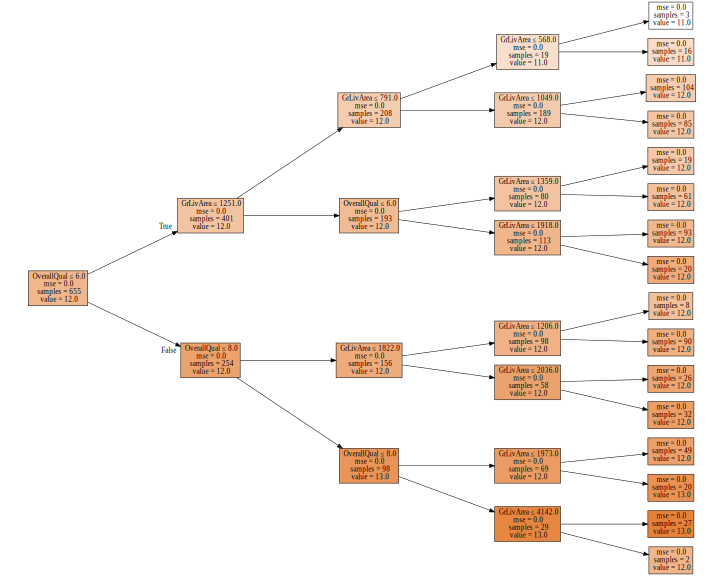

In [54]:
X_train = X_train[['OverallQual', 'GrLivArea']]
rf_simple = RandomForestRegressor(n_estimators = 5, n_jobs = -1, random_state = 1, max_depth = 4)
rf_simple.fit(X_train, y_train)
print(rmse(y_train, rf_simple.predict(X_train)))
print(rmse(y_valid, rf_simple.predict(X_valid[['OverallQual', 'GrLivArea']])))
draw_tree(rf_simple[0], df = X_train, ratio = 0.8)



In [ ]:
rf_mine = RandomForest(X_train.shape[0], n_trees = 5, min_samples_leaf = 3)
rf_mine.fit(X_train, y_train)
print(rf_mine.trees[0])
print(rf_mine.trees[0].rightTree)
print(rmse(y_train, rf_mine.predict(X_train)))
print(rmse(y_valid, rf_mine.predict(X_valid)))